# Intaling Required libaries


In [ ]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install matplotlib

# Import statements


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Imporing Dataset

In [ ]:
# Read the dataset
dataset = pd.read_csv(r"avocado.csv")

# Store a copy of the dataset for later use
dat = dataset.copy()


# Filling Missing Values


In [ ]:
for yr in dat['year'].unique():
    for rg in dat['region'].unique():
        # Filter the DataFrame based on 'year' and 'region'
        condition = (dat['year'] == yr) & (dat['region'] == rg)
        filtered_data = dat[condition].copy()  # Make a copy to avoid SettingWithCopyWarning

        # Exclude non-numeric columns from the imputation process
        numeric_columns = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']
        filtered_data[numeric_columns] = filtered_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

        # Initialize and fit the imputer
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer.fit(filtered_data[numeric_columns])

        # Transform and assign values back to the DataFrame
        dat.loc[condition, numeric_columns] = imputer.transform(filtered_data[numeric_columns])


# Convert date to number of days from

In [ ]:
def crt_dat(dt):
    tem= datetime.strptime(dt, "%Y-%m-%d")
    epoch = datetime(2015, 1, 1)
    days_from_epoch = (tem - epoch).days
    return days_from_epoch

print(dat['region'].isna().any())
dat['Date']= dat['Date'].apply(crt_dat)


False


# Defining function to remove outliers

In [ ]:

def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 -( 1.5 * IQR ) # Adjusted multiplier to 1.5 for typical IQR outlier rule
    upper_bound = Q3 + (1.5 * IQR  )# Adjusted multiplier to 1.5 for typical IQR outlier rule
    def rm(dt):
        if (dt < lower_bound) or (dt > upper_bound):
            return np.nan
        return dt
    return data.apply(rm)

# Function to remove outliers using z-score method
def remove_outliers_zscore(data):
    numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
    z_scores = zscore(numeric_data)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)  # Adjust the threshold as needed
    return data[filtered_entries]

columns_to_normalize = ['AveragePrice', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags','Total Volume']
columns_to_normalize_tw = [ '4046',  '4770',  'Large Bags']


# Data before Normalisation


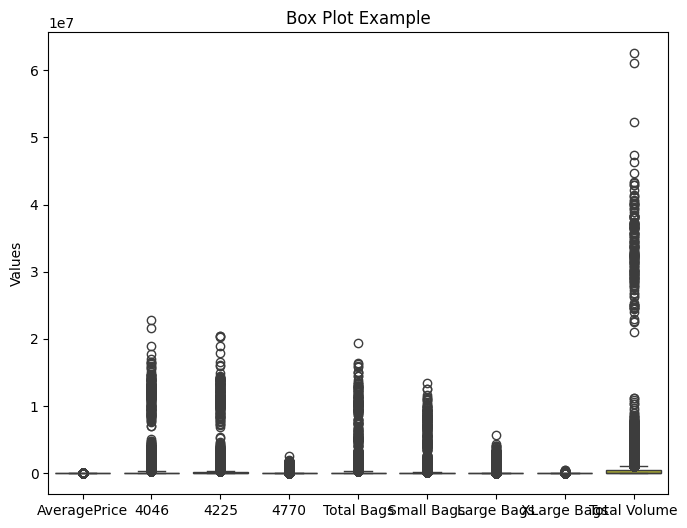

In [ ]:
plt.figure(figsize=(8, 6))
# plt.boxplot(dat, labels=columns_to_normalize, patch_artist=True, showmeans=True)
sns.boxplot(data=dat[columns_to_normalize])
plt.title('Box Plot Example')
plt.ylabel('Values')
plt.show()


# Removing Outliers

In [ ]:

# dat = remove_outliers_zscore(dat)

for i in columns_to_normalize:
    dat[i] = remove_outliers_iqr(dat[i])
    # dat = dat.dropna(subset=[i])
dat = dat.dropna()
# for i in columns_to_normalize_tw:
#     dat[i] = remove_outliers_iqr(dat[i])
#     dat = dat.dropna(subset=[i])

# for j in range(0,15):
#     for i in columns_to_normalize_tw:
#         dat[i] = remove_outliers_iqr(dat[i])
#         dat = dat.dropna(subset=[i])
# dat.to_csv('avooutl.csv')
dat.reset_index(drop=True, inplace=True)


# Normalise Data

In [ ]:
columns_to_normalize.append("Date")
tem = dat[columns_to_normalize]
# print(tem)
norm = Normalizer()

tem = norm.fit_transform(tem)
# print(tem)

dat.reset_index(drop=True, inplace=True)

dat[columns_to_normalize] = pd.DataFrame(tem, columns=columns_to_normalize)

print(pd.DataFrame(tem, columns=columns_to_normalize))
columns_to_normalize_r = ['remainder__AveragePrice', 'remainder__4046', 'remainder__4225', 'remainder__4770', 'remainder__Total Bags', 'remainder__Small Bags', 'remainder__Large Bags', 'remainder__XLarge Bags','remainder__Total Volume']




       AveragePrice      4046      4225      4770  Total Bags  Small Bags  \
0          0.000016  0.012182  0.639869  0.000566    0.102192    0.101096   
1          0.000019  0.009365  0.620009  0.000810    0.132027    0.130673   
2          0.000006  0.004926  0.676638  0.000809    0.050494    0.049855   
3          0.000010  0.010562  0.671540  0.000677    0.054218    0.052970   
4          0.000019  0.013878  0.646224  0.001117    0.091158    0.088244   
...             ...       ...       ...       ...         ...         ...   
11533      0.000064  0.080135  0.059865  0.000000    0.528447    0.511541   
11534      0.000089  0.061687  0.177628  0.000000    0.479586    0.462773   
11535      0.000097  0.061596  0.126756  0.037619    0.485470    0.483284   
11536      0.000085  0.067305  0.131340  0.032031    0.483302    0.481099   
11537      0.000066  0.117289  0.095464  0.009097    0.486783    0.485729   

       Large Bags  XLarge Bags  Total Volume      Date  
0        0.001096 

# One Hotencoding

In [ ]:
label_encoder = LabelEncoder()

# Fit label encoder and transform the specified column
dat['type'] = label_encoder.fit_transform(dat['type'])




ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['region','year'])], remainder='passthrough')

# Fit and transform the data
transformed_data = ct.fit_transform(dat)
transformed_data_dense = transformed_data.toarray()

# Convert the dense array to a DataFrame
dat = pd.DataFrame(transformed_data_dense, columns=ct.get_feature_names_out())
# print(dat)



# Data after Preprocessing

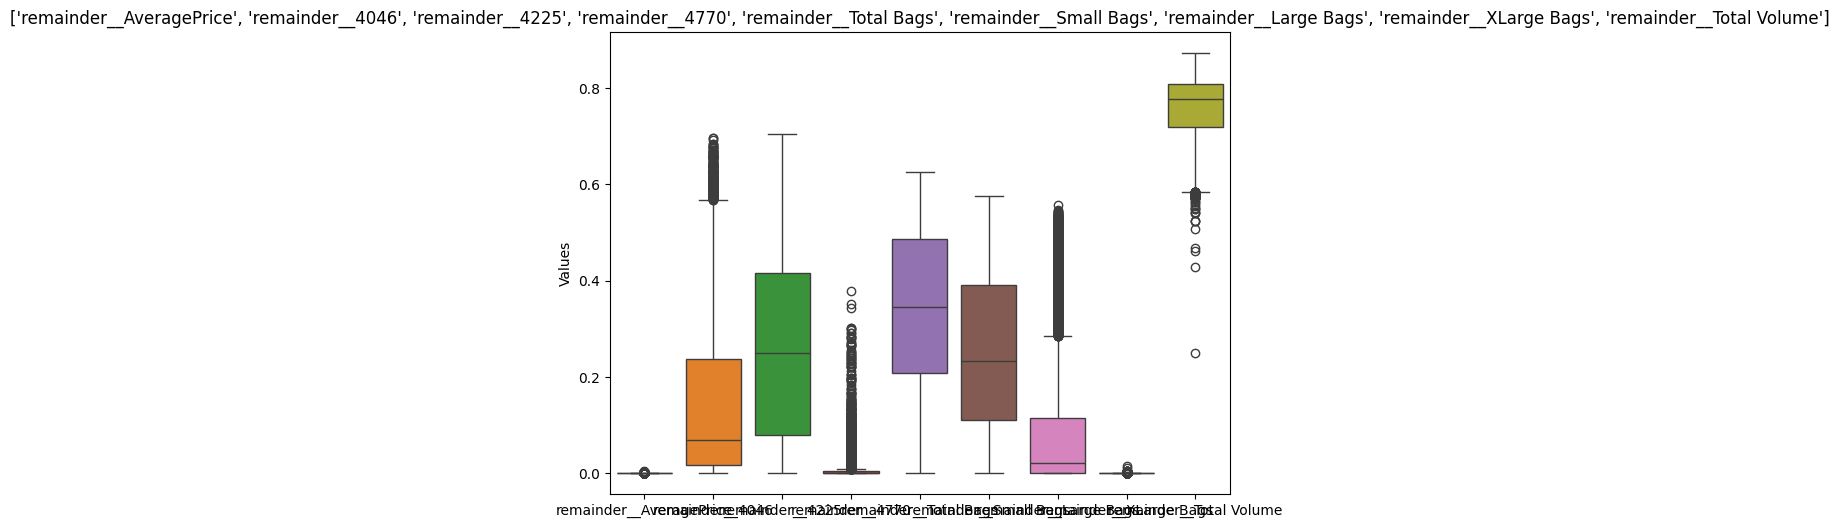

In [ ]:
plt.figure(figsize=(8, 6))
    # plt.boxplot(dat, labels=columns_to_normalize, patch_artist=True, showmeans=True)
sns.boxplot(data=dat[columns_to_normalize_r])
plt.title(columns_to_normalize_r)
plt.ylabel('Values')
plt.show()

Total Volume vs Total Bags

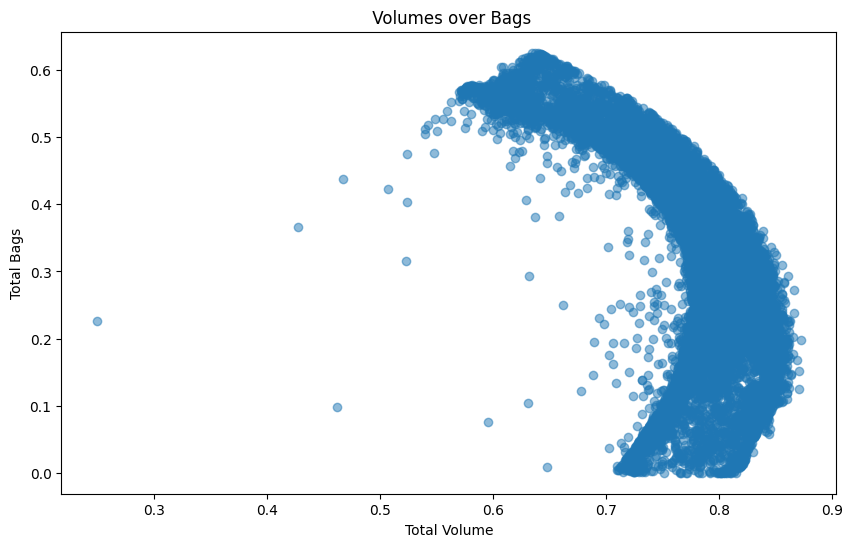

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(dat['remainder__Total Volume'], dat['remainder__Total Bags'], alpha=0.5)
plt.title(' Volumes over Bags')
plt.xlabel('Total Volume')
plt.ylabel('Total Bags')
plt.show()


# Year vs AvgPrice

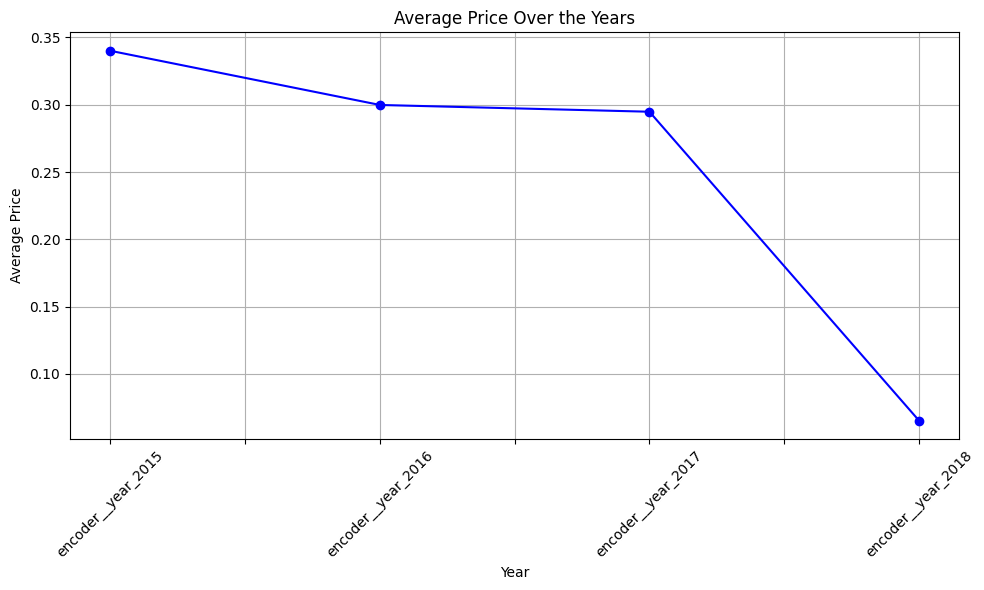

In [ ]:

year_columns = ['encoder__year_2015', 'encoder__year_2016', 'encoder__year_2017', 'encoder__year_2018']
average_price_column = 'remainder__AveragePrice'

# Extract relevant columns
df_year_avgprice = dat[year_columns + [average_price_column]]

# Melt the DataFrame to have years as one column and average price as another column
df_year_avgprice_melted = df_year_avgprice.melt(value_vars=year_columns, var_name='Year', value_name='AveragePrice')

# Group by year and calculate the average price
average_price_by_year = df_year_avgprice_melted.groupby('Year')['AveragePrice'].mean()

# Plot the average price over the years
plt.figure(figsize=(10, 6))
average_price_by_year.plot(kind='line', marker='o', color='b')
plt.title('Average Price Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

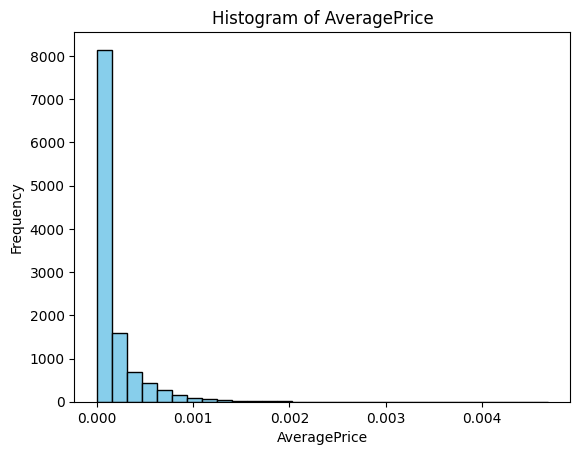

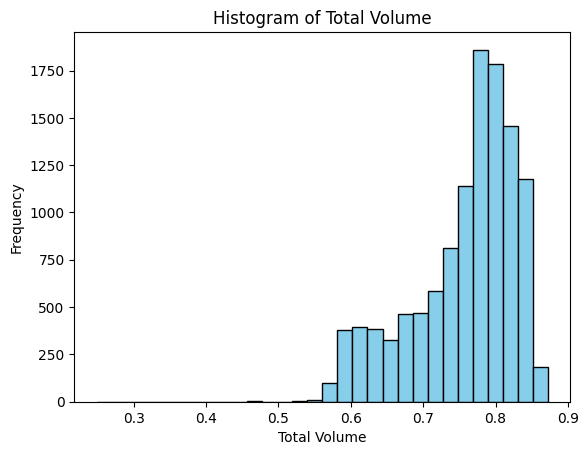

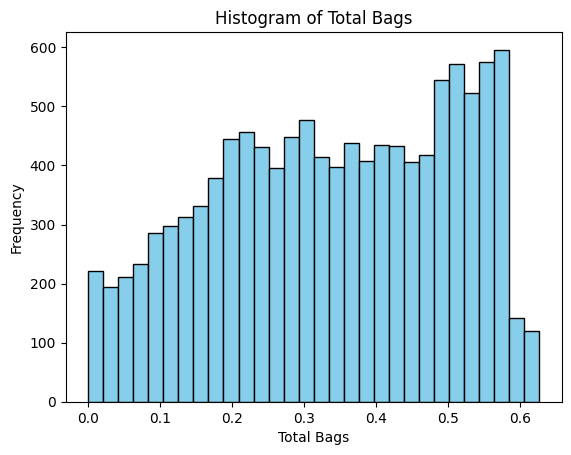

In [ ]:

plt.hist(dat['remainder__AveragePrice'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of AveragePrice' )
plt.xlabel('AveragePrice')
plt.ylabel('Frequency')
plt.show()


plt.hist(dat["remainder__Total Volume"], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Volume' )
plt.xlabel("Total Volume")
plt.ylabel('Frequency')
plt.show()


plt.hist(dat["remainder__Total Bags"], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Bags' )
plt.xlabel("Total Bags")
plt.ylabel('Frequency')
plt.show()

#Print final data

In [ ]:
dat.to_csv(r'avocado_processed.csv')
print(dat.columns)

Index(['encoder__region_Albany', 'encoder__region_Atlanta',
       'encoder__region_BaltimoreWashington', 'encoder__region_Boise',
       'encoder__region_Boston', 'encoder__region_BuffaloRochester',
       'encoder__region_California', 'encoder__region_Charlotte',
       'encoder__region_Chicago', 'encoder__region_CincinnatiDayton',
       'encoder__region_Columbus', 'encoder__region_DallasFtWorth',
       'encoder__region_Denver', 'encoder__region_Detroit',
       'encoder__region_GrandRapids', 'encoder__region_GreatLakes',
       'encoder__region_HarrisburgScranton',
       'encoder__region_HartfordSpringfield', 'encoder__region_Houston',
       'encoder__region_Indianapolis', 'encoder__region_Jacksonville',
       'encoder__region_LasVegas', 'encoder__region_LosAngeles',
       'encoder__region_Louisville', 'encoder__region_MiamiFtLauderdale',
       'encoder__region_Midsouth', 'encoder__region_Nashville',
       'encoder__region_NewOrleansMobile', 'encoder__region_NewYork',
      

#import liberies for regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Spliting the data and performing regression

In [ ]:
# Splitting the data into features (X) and target variable (Y)
X = dat.drop(columns=['remainder__AveragePrice'])  # Features
Y = dat['remainder__AveragePrice']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Training the model
model.fit(X_train, Y_train)


LinearRegression()

# Predict Using Test data and calculate Mean Squared Error

In [ ]:
# Making predictions
Y_pred = model.predict(X_test)

# Calculating mean squared error
mse = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.973043615008966e-08


#Scatterplots independent variable against the dependent variable

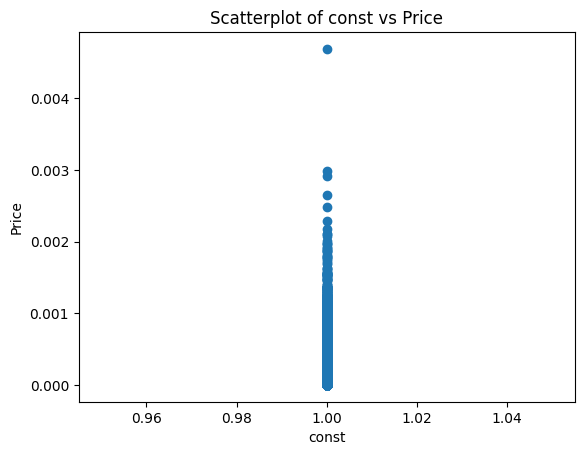

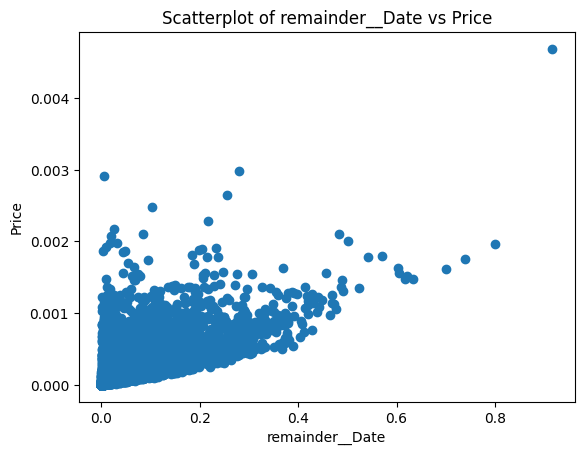

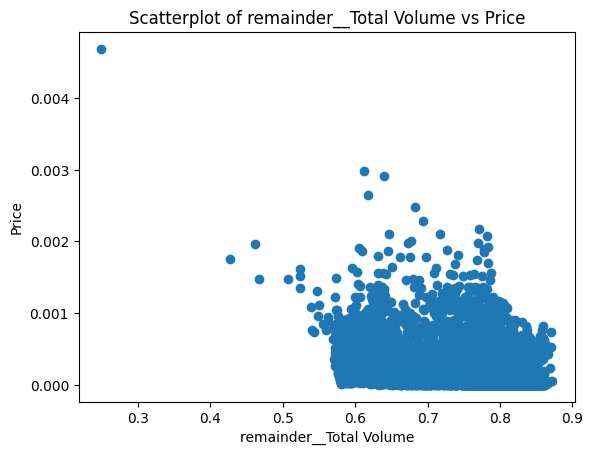

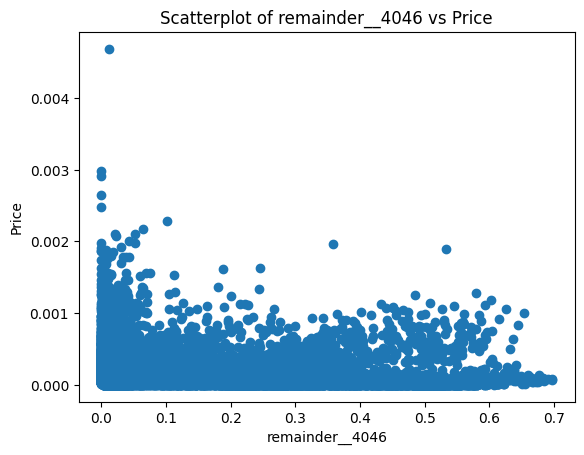

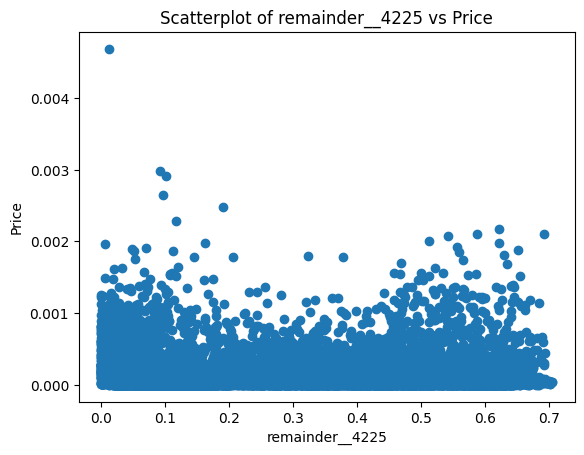

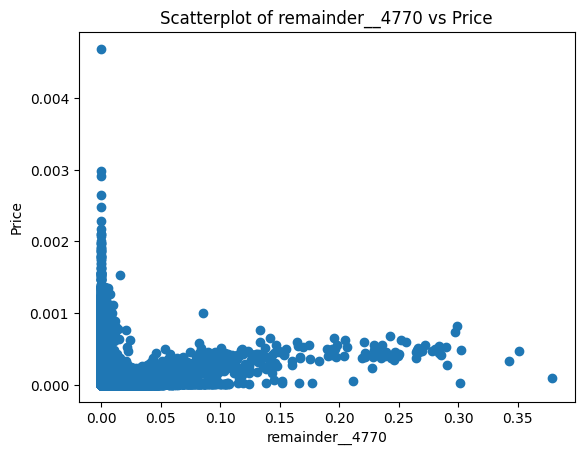

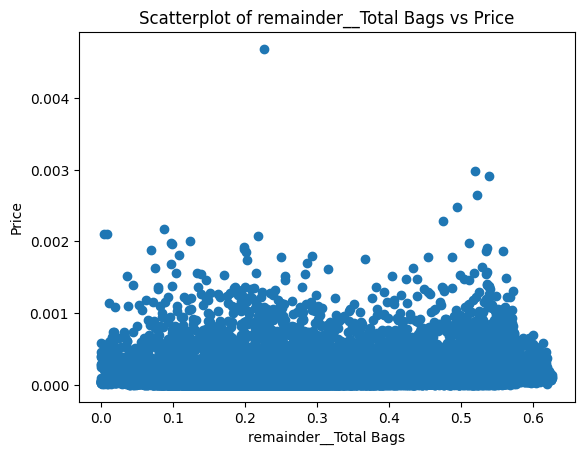

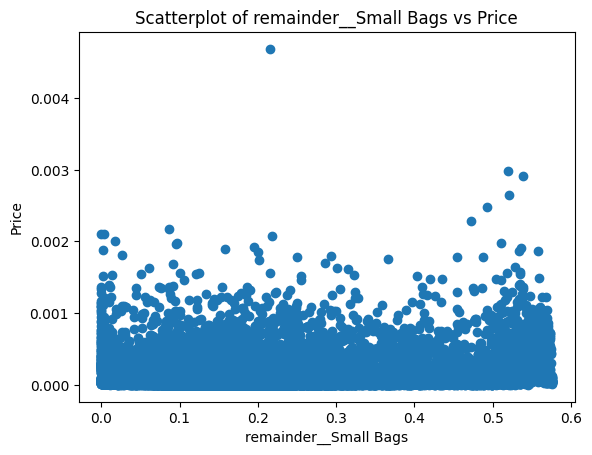

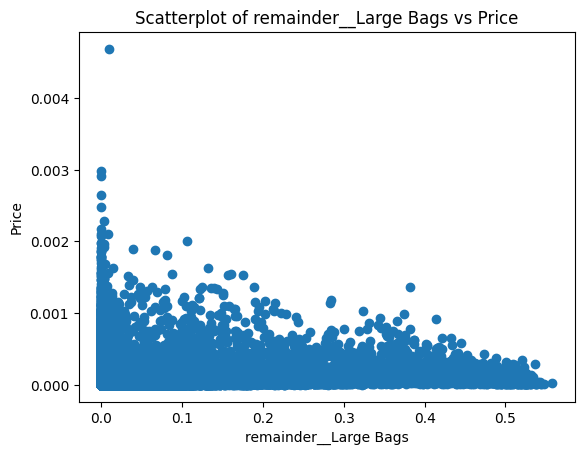

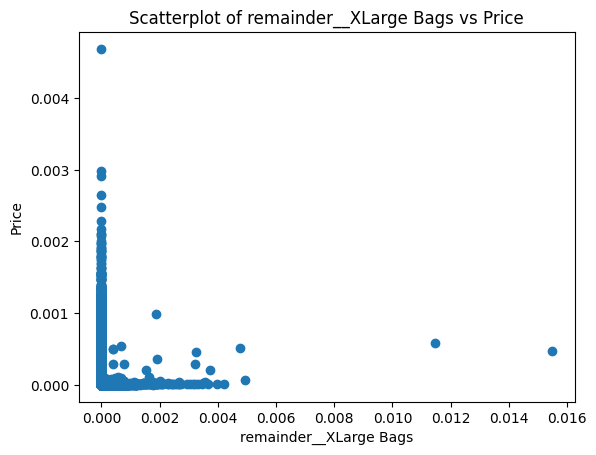

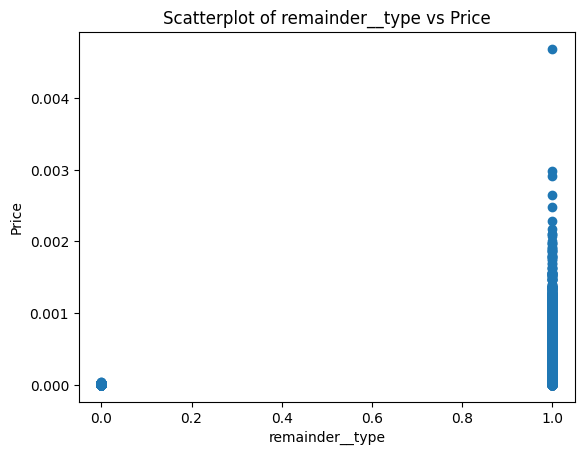

In [ ]:
for column in X.columns:
    plt.scatter(X[column], Y)
    plt.title(f"Scatterplot of {column} vs Price")
    plt.xlabel(column)
    plt.ylabel("Price")
    plt.show()

#Print Correlation Matrix

Index(['encoder__region_Albany', 'encoder__region_Atlanta',
       'encoder__region_BaltimoreWashington', 'encoder__region_Boise',
       'encoder__region_Boston', 'encoder__region_BuffaloRochester',
       'encoder__region_California', 'encoder__region_Charlotte',
       'encoder__region_Chicago', 'encoder__region_CincinnatiDayton',
       'encoder__region_Columbus', 'encoder__region_DallasFtWorth',
       'encoder__region_Denver', 'encoder__region_Detroit',
       'encoder__region_GrandRapids', 'encoder__region_GreatLakes',
       'encoder__region_HarrisburgScranton',
       'encoder__region_HartfordSpringfield', 'encoder__region_Houston',
       'encoder__region_Indianapolis', 'encoder__region_Jacksonville',
       'encoder__region_LasVegas', 'encoder__region_LosAngeles',
       'encoder__region_Louisville', 'encoder__region_MiamiFtLauderdale',
       'encoder__region_Midsouth', 'encoder__region_Nashville',
       'encoder__region_NewOrleansMobile', 'encoder__region_NewYork',
      

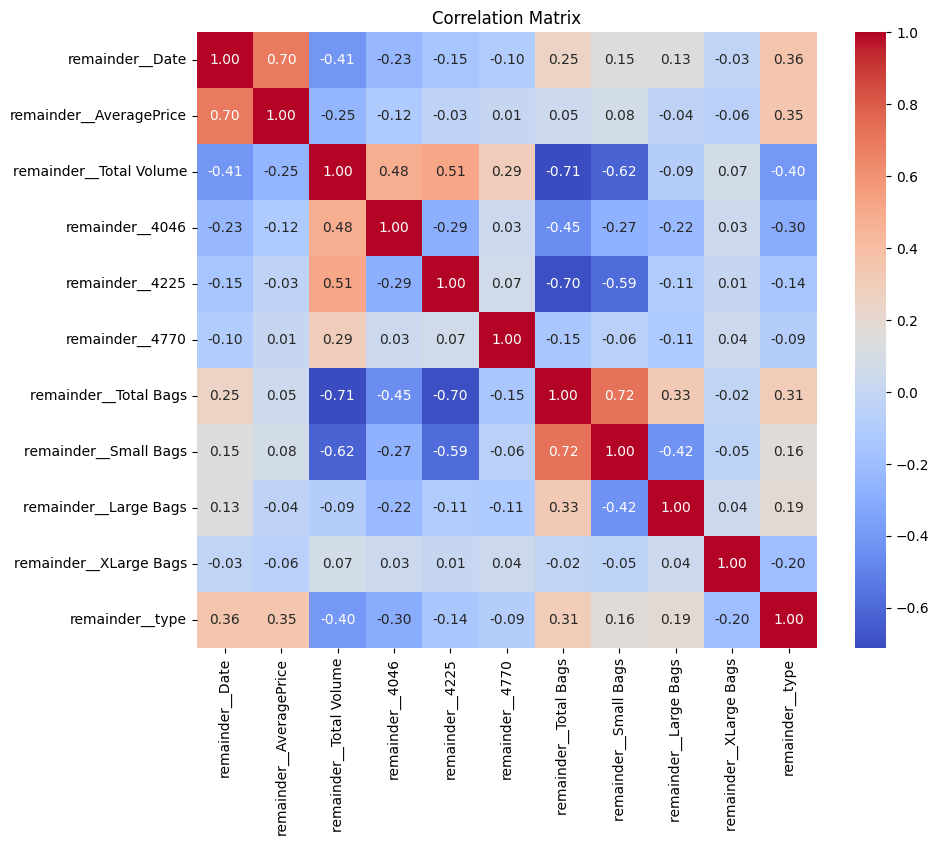

In [ ]:
print(dat.columns)
print()
corr_coloums = ['remainder__Date', 'remainder__AveragePrice',
       'remainder__Total Volume', 'remainder__4046', 'remainder__4225',
       'remainder__4770', 'remainder__Total Bags', 'remainder__Small Bags',
       'remainder__Large Bags', 'remainder__XLarge Bags', 'remainder__type'] #coloums except regions
# Calculating correlation matrix
correlation_matrix = dat[corr_coloums].corr()
rowcor = dat['remainder__AveragePrice']
correlations = {}
#calculate correlation
for column in corr_coloums:
  if column=='remainder__AveragePrice':
    continue
  correlations[column] = rowcor.corr(dat[column])


# Print the correlations
print(correlations)
#seperate positive and negative correlated items
final_pos_features = [col for col, corr in correlations.items() if corr > 0]
final_neg_features = [col for col, corr in correlations.items() if corr < 0]


# Print correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


#Using corelation finding threshold to find rreveland features

In [ ]:

positive_corr_sum = 0
positive_corr_count = 0
negative_corr_sum = 0
negative_corr_count = 0

# Loop over correlation coefficients
for corr in correlations.values():
    if corr > 0:
        positive_corr_sum += corr
        positive_corr_count += 1
    elif corr < 0:
        negative_corr_sum += corr
        negative_corr_count += 1

# Calculate average of positive and negative correlations
average_positive_corr = positive_corr_sum / positive_corr_count if positive_corr_count > 0 else 0
average_negative_corr = negative_corr_sum / negative_corr_count if negative_corr_count > 0 else 0

print("Average of positive correlation coefficients:", average_positive_corr)
print("Average of negative correlation coefficients:", average_negative_corr)


Average of positive correlation coefficients: 0.2348811969399037
Average of negative correlation coefficients: -0.09935952228445713


# Extract positive and negative corelated features array

In [ ]:

final_positive_features = []
final_negative_features = []

# Loop over correlation coefficients again to identify final features
for key, corr in correlations.items():
    if corr > average_positive_corr:
        final_positive_features.append(key)
    elif corr < average_negative_corr:
        final_negative_features.append(key)

print("Final positive features:", final_positive_features)
print("Final negative features:", final_negative_features)

final_features = final_positive_features + final_negative_features


Final positive features: ['remainder__Date', 'remainder__type']
Final negative features: ['remainder__Total Volume', 'remainder__4046']


# strength of the relationship between independent and dependent variables

Using all features

In [ ]:

X = dat[corr_coloums].drop(columns =['remainder__AveragePrice']) # Features

Y = dat['remainder__AveragePrice']  # Target variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary statistics
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.537
Model:                                 OLS   Adj. R-squared:                  0.537
Method:                      Least Squares   F-statistic:                     1339.
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                             19:57:47   Log-Likelihood:                 83580.
No. Observations:                    11538   AIC:                        -1.671e+05
Df Residuals:                        11527   BIC:                        -1.671e+05
Df Model:                               10                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

Using final features extracted

In [ ]:
X = dat[final_features] # Features
Y = dat['remainder__AveragePrice']  # Target variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary statistics
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.503
Model:                                 OLS   Adj. R-squared:                  0.502
Method:                      Least Squares   F-statistic:                     2913.
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                             19:47:41   Log-Likelihood:                 83162.
No. Observations:                    11538   AIC:                        -1.663e+05
Df Residuals:                        11533   BIC:                        -1.663e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

# Using positive,negative feeatures

In [ ]:
X = dat[final_pos_features]# Features
Y = dat['remainder__AveragePrice']  # Target variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary statistics
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.536
Model:                                 OLS   Adj. R-squared:                  0.535
Method:                      Least Squares   F-statistic:                     2659.
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                             19:47:44   Log-Likelihood:                 83557.
No. Observations:                    11538   AIC:                        -1.671e+05
Df Residuals:                        11532   BIC:                        -1.671e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
X = dat[final_neg_features] # Features
Y = dat['remainder__AveragePrice']  # Target variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary statistics
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.087
Model:                                 OLS   Adj. R-squared:                  0.087
Method:                      Least Squares   F-statistic:                     220.5
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):          2.02e-225
Time:                             19:47:47   Log-Likelihood:                 79660.
No. Observations:                    11538   AIC:                        -1.593e+05
Df Residuals:                        11532   BIC:                        -1.593e+05
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

# strength of the relationship between independent and dependent variables

In [ ]:

for i in corr_coloums:
  X = dat[i] # Features
  Y = dat['remainder__AveragePrice']  # Target variable

  # Add constant term for intercept
  X = sm.add_constant(X)

  # Fit the linear regression model
  model = sm.OLS(Y, X).fit()

  # Print the summary statistics
  print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.484
Model:                                 OLS   Adj. R-squared:                  0.484
Method:                      Least Squares   F-statistic:                 1.080e+04
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                             19:48:05   Log-Likelihood:                 82946.
No. Observations:                    11538   AIC:                        -1.659e+05
Df Residuals:                        11536   BIC:                        -1.659e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

#Final Features

Depending on the observaation of various independend variable and corelatioon with the dependend variable.We chose the most relevant features and find the results.

In [ ]:
temp_arr = ["remainder__4046","remainder__4225","remainder__4770","remainder__Small Bags",'remainder__type',"remainder__Date",'remainder__Large Bags']
# tem2 = ["remainder__Date",'remainder__Total Volume',"remainder__4046","remainder__4225","remainder__4770",'remainder__Total Bags','remainder__Small Bags','remainder__Large Bags']
# tem3 = ['remainder__Total Volume','remainder__type',"remainder__Date"]
X = dat[temp_arr] # Features
Y = dat['remainder__AveragePrice']  # Target variable

# Add constant term for intercept
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X).fit()

# Print the summary statistics
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     remainder__AveragePrice   R-squared:                       0.537
Model:                                 OLS   Adj. R-squared:                  0.537
Method:                      Least Squares   F-statistic:                     1673.
Date:                     Tue, 19 Mar 2024   Prob (F-statistic):               0.00
Time:                             19:53:14   Log-Likelihood:                 83579.
No. Observations:                    11538   AIC:                        -1.671e+05
Df Residuals:                        11529   BIC:                        -1.671e+05
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

# Inference

From the above expriment we find that certain features like

-> remainder_XLarge bags are weakly related with Average price as they tend to buy in lage number of large and small bags

-> the Total bags are not included because it is aproximate equal to sum of large and small bags

-> Similarly Total Voloume is samll as sum of individual types of avacado So it was excluded


# Conclusion


Thus by removing weakly corelated and irrevelant features we could increase our accuracy to 53.7% by also using less number of variables into account and also removed multicolinearity from our database.